In [14]:
%load_ext autoreload
%autoreload 2

from collect_experiments import display_experiments, display_experiments_helper, BLISSExperiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


drakes_test {'ddg': 1.0762512499999999, 'ddg_std': 0.8210351286830646, 'pos_ddg_prop': 0.8587239583333334, 'scrmsd': 0.8988032639026642, 'scrmsd_std': 1.202034489322876, 'low_scrmsd_prop': 0.9342447916666666, 'success_rate': 0.7975260416666666, 'll': -144.11238861083984, 'll_std': 41.5608073079779}
pretrained_7JJK_ddg_spectral_N=10_stepsperlevel=1 {'ddg': 1.25633545, 'ddg_std': 0.5655456093129736, 'pos_ddg_prop': 0.9375, 'll': -122.76164627075195, 'll_std': 3.1965937902656094}
pretrained_test_ddg_beam_N=10_W=1_stepsperlevel=1 {'ddg': 0.98094535, 'ddg_std': 1.2155220535585725, 'pos_ddg_prop': 0.744140625, 'll': -131.2860565185547, 'll_std': 42.15715666867591}
pretrained_test_ddg_bon_N=10 {'ddg': 0.329366505, 'ddg_std': 1.2250946129260123, 'pos_ddg_prop': 0.59375, 'll': -127.4770622253418, 'll_std': 42.27576025028332}
pretrained_test {'ddg': -0.551643185, 'ddg_std': 1.284352746810967, 'pos_ddg_prop': 0.3606770833333333, 'scrmsd': 0.8672547936439514, 'scrmsd_std': 0.8554886584567372, 'low

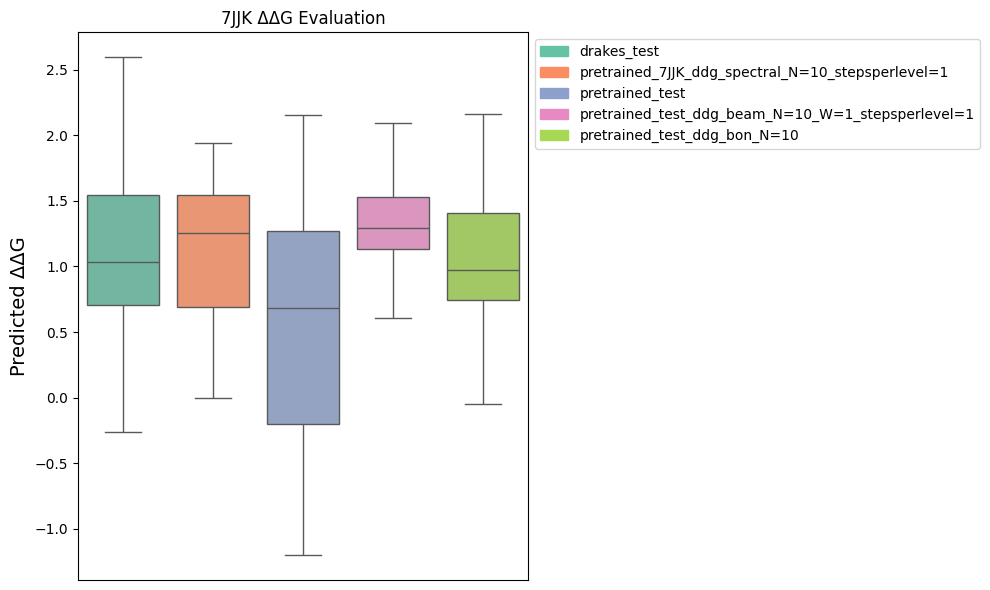

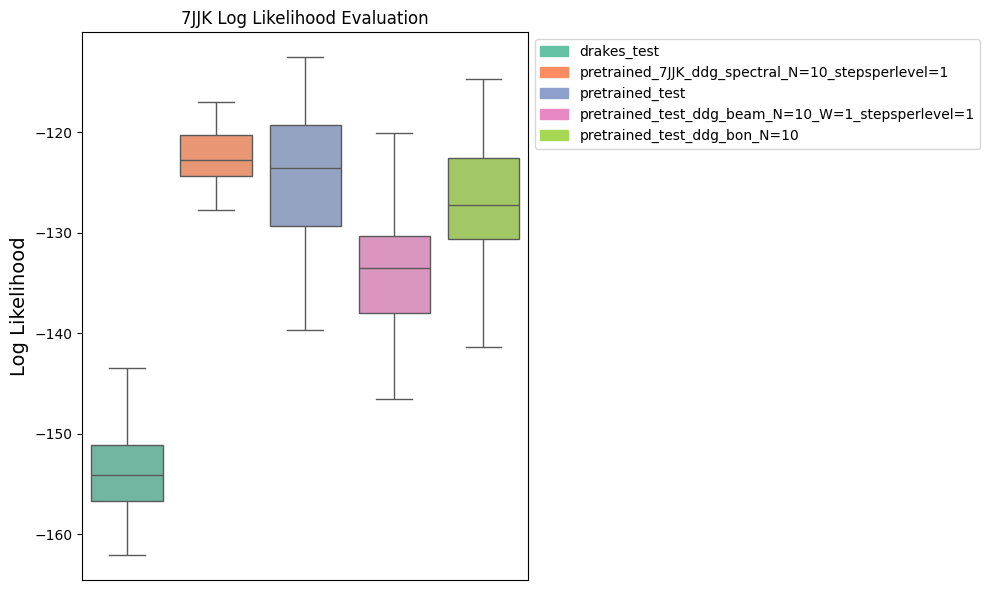

In [15]:
display_experiments(n=10, oracle='ddg', dataset='test', target_protein='7JJK')

In [46]:
from matplotlib import pyplot as plt
import random 
import numpy as np

def evaluate_ddg_ll_corr_mult(df_list, labels, protein, title='', selected_samples=None):
    for i, df in enumerate(df_list):
        df = df[df['protein_name'] == protein + ".pdb"]
        pre_ddg = df['ddg_eval']
        pre_protgpt = df['loglikelihood']
        if selected_samples is not None and len(pre_ddg) > selected_samples: # type: ignore
            ids = random.sample(range(len(pre_ddg)), selected_samples) # type: ignore
            pre_ddg = np.array(pre_ddg)[ids]
            pre_protgpt = np.array(pre_protgpt)[ids]
        plt.scatter(pre_ddg, pre_protgpt, label=labels[i])
    plt.xlabel('ΔΔG')
    plt.ylabel('Log Likelihood')
    plt.title(title)
    plt.legend()
    plt.show()

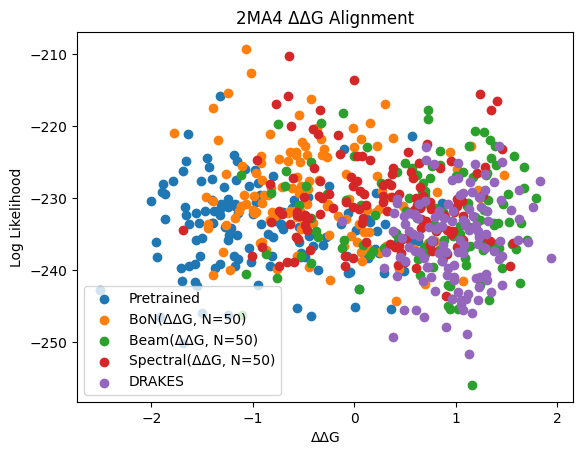

In [52]:
exps = []
bliss_dir = '/home/shai/BLISS_Experiments/DRAKES/'
exp_dir = 'DRAKES/drakes_protein/fmif/eval_results/'
base_path = bliss_dir + exp_dir + 'test' + '/'

exps.append(BLISSExperiment(
    name='Pretrained',
    base_path=base_path,
    model='pretrained',
    dataset='test'))

exps.append(BLISSExperiment(
    name='BoN(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='bon',
    align_n=50))

exps.append(BLISSExperiment(
    name='Beam(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='beam',
    align_n=50,
    beam_w=1))

exps.append(BLISSExperiment(
    name='Spectral(ΔΔG, N=50)',
    base_path=base_path,
    model='pretrained',
    dataset='test',
    oracle_mode='ddg',
    align_type='spectral',
    align_n=50,
    beam_w=1))

exps.append(BLISSExperiment(
    name='DRAKES',
    base_path=base_path,
    model='drakes',
    dataset='test'))

dfs = [e.get_df() for e in exps]
labels = [e.name for e in exps]

evaluate_ddg_ll_corr_mult(dfs, labels, '2MA4', selected_samples=None, title='2MA4 ΔΔG Alignment')